In [16]:
import tensorflow as tf

class GradientLayer(tf.keras.layers.Layer):
    """
    Custom layer to compute 1st and 2nd derivatives for the wave equation.

    Attributes:
        model: keras network model.
    """

    def __init__(self, model, **kwargs):
        """
        Args:
            model: keras network model.
        """

        self.model = model
        super().__init__(**kwargs)

    def call(self, tx):
        """
        Computing 1st and 2nd derivatives for the wave equation.

        Args:
            tx: input variables (t, x).

        Returns:
            u: network output.
            du_dt: 1st derivative of t.
            du_dx: 1st derivative of x.
            d2u_dt2: 2nd derivative of t.
            d2u_dx2: 2nd derivative of x.
        """

        with tf.GradientTape() as g:
            g.watch(tx)
            with tf.GradientTape() as gg:
                gg.watch(tx)
                u = self.model(tx)
            du_dtx = gg.batch_jacobian(u, tx)
            du_dt = du_dtx[..., 0]
            du_dx = du_dtx[..., 1]
        d2u_dtx2 = g.batch_jacobian(du_dtx, tx)
        d2u_dt2 = d2u_dtx2[..., 0, 0]
        d2u_dx2 = d2u_dtx2[..., 1, 1]

        return u, du_dt, du_dx, d2u_dt2, d2u_dx2

In [17]:
# network.py
import tensorflow as tf

class Network:
    """
    Build a physics informed neural network (PINN) model for the wave equation.
    """

    @classmethod
    def build(cls, num_inputs=2, layers=[32, 16, 16, 32], activation='tanh', num_outputs=1):
        """
        Build a PINN model for the wave equation with input shape (t, x) and output shape u(t, x).

        Args:
            num_inputs: number of input variables. Default is 2 for (t, x).
            layers: number of hidden layers.
            activation: activation function in hidden layers.
            num_outpus: number of output variables. Default is 1 for u(t, x).

        Returns:
            keras network model.
        """

        # input layer
        inputs = tf.keras.layers.Input(shape=(num_inputs,))
        # hidden layers
        x = inputs
        for layer in layers:
            x = tf.keras.layers.Dense(layer, activation=activation,
                kernel_initializer='he_normal')(x)
        # output layer
        outputs = tf.keras.layers.Dense(num_outputs,
            kernel_initializer='he_normal')(x)

        return tf.keras.models.Model(inputs=inputs, outputs=outputs)


In [18]:
# optimizer.py
import scipy.optimize
import numpy as np
import tensorflow as tf

class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.

    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: logging metrics.
        progbar: progress bar.
    """

    def __init__(self, model, x_train, y_train, factr=1e5, m=50, maxls=50, maxiter=15000):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger()
        # self.progbar = tf.keras.callbacks.ProgbarLogger(
        #     count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.

        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.

        Args:
            x: input data.

        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.

        Args:
            weights: flatten weights.

        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.

        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()


In [19]:
# pinn.py
import tensorflow as tf
#from .layer import GradientLayer

class PINN:
    """
    Build a physics informed neural network (PINN) model for the wave equation.

    Attributes:
        network: keras network model with input (t, x) and output u(t, x).
        c: wave velocity.
        grads: gradient layer.
    """

    def __init__(self, network, c=1):
        """
        Args:
            network: keras network model with input (t, x) and output u(t, x).
            c: wave velocity. Default is 1.
        """

        self.network = network
        self.c = c
        self.grads = GradientLayer(self.network)

    def build(self):
        """
        Build a PINN model for the wave equation.

        Returns:
            PINN model for the projectile motion with
                input: [ (t, x) relative to equation,
                         (t=0, x) relative to initial condition,
                         (t, x=bounds) relative to boundary condition ],
                output: [ u(t,x) relative to equation,
                          u(t=0, x) relative to initial condition,
                          du_dt(t=0, x) relative to initial derivative of t,
                          u(t, x=bounds) relative to boundary condition ]
        """

        # equation input: (t, x)
        tx_eqn = tf.keras.layers.Input(shape=(2,))
        # initial condition input: (t=0, x)
        tx_ini = tf.keras.layers.Input(shape=(2,))
        # boundary condition input: (t, x=-1) or (t, x=+1)
        tx_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients
        _, _, _, d2u_dt2, d2u_dx2 = self.grads(tx_eqn)

        # equation output being zero
        u_eqn = d2u_dt2 - self.c*self.c * d2u_dx2
        # initial condition output
        u_ini, du_dt_ini, _, _, _ = self.grads(tx_ini)
        # boundary condition output
        u_bnd = self.network(tx_bnd)  # dirichlet
        #_, _, u_bnd, _, _ = self.grads(tx_bnd)  # neumann

        # build the PINN model for the wave equation
        return tf.keras.models.Model(
            inputs=[tx_eqn, tx_ini, tx_bnd],
            outputs=[u_eqn, u_ini, du_dt_ini, u_bnd])


In [20]:
# suppress tensorflow warnings (must be called before importing tensorflow)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

Optimizer: L-BFGS-B (maxiter=15000)
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 487s 32ms/step
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


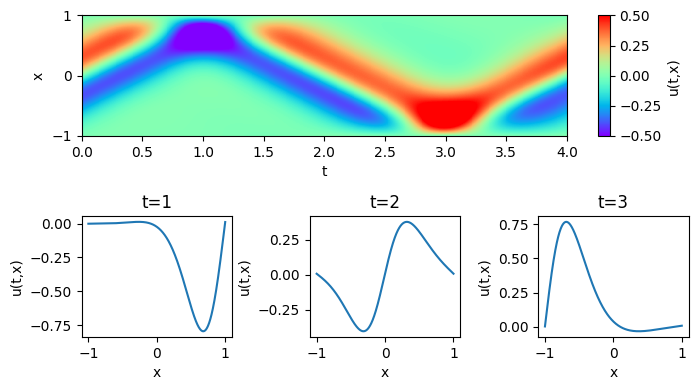

In [21]:
#import lib.tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
#from lib.pinn import PINN
#from lib.network import Network
#from lib.optimizer import L_BFGS_B

def u0(tx, c=1, k=2, sd=0.5):
    """
    Initial wave form.

    Args:
        tx: variables (t, x) as tf.Tensor.
        c: wave velocity.
        k: wave number.
        sd: standard deviation.

    Returns:
        u(t, x) as tf.Tensor.
    """

    t = tx[..., 0, None]
    x = tx[..., 1, None]
    z = k*x - (c*k)*t
    return tf.sin(z) * tf.exp(-(0.5*z/sd)**2)

def du0_dt(tx):
    """
    First derivative of t for the initial wave form.

    Args:
        tx: variables (t, x) as tf.Tensor.

    Returns:
        du(t, x)/dt as tf.Tensor.
    """

    with tf.GradientTape() as g:
        g.watch(tx)
        u = u0(tx)
    du_dt = g.batch_jacobian(u, tx)[..., 0]
    return du_dt

if __name__ == '__main__':
    """
    Test the physics informed neural network (PINN) model for the wave equation.
    """

    # number of training samples
    num_train_samples = 10000
    # number of test samples
    num_test_samples = 1000

    # build a core network model
    network = Network.build()
    network.summary()
    # build a PINN model
    pinn = PINN(network).build()

    # create training input
    tx_eqn = np.random.rand(num_train_samples, 2)
    tx_eqn[..., 0] = 4*tx_eqn[..., 0]                # t =  0 ~ +4
    tx_eqn[..., 1] = 2*tx_eqn[..., 1] - 1            # x = -1 ~ +1
    tx_ini = np.random.rand(num_train_samples, 2)
    tx_ini[..., 0] = 0                               # t = 0
    tx_ini[..., 1] = 2*tx_ini[..., 1] - 1            # x = -1 ~ +1
    tx_bnd = np.random.rand(num_train_samples, 2)
    tx_bnd[..., 0] = 4*tx_bnd[..., 0]                # t =  0 ~ +4
    tx_bnd[..., 1] = 2*np.round(tx_bnd[..., 1]) - 1  # x = -1 or +1
    # create training output
    u_zero = np.zeros((num_train_samples, 1))
    u_ini = u0(tf.constant(tx_ini)).numpy()
    du_dt_ini = du0_dt(tf.constant(tx_ini)).numpy()

    # train the model using L-BFGS-B algorithm
    x_train = [tx_eqn, tx_ini, tx_bnd]
    y_train = [u_zero, u_ini, du_dt_ini, u_zero]
    lbfgs = L_BFGS_B(model=pinn, x_train=x_train, y_train=y_train)
    lbfgs.fit()

    # predict u(t,x) distribution
    t_flat = np.linspace(0, 4, num_test_samples)
    x_flat = np.linspace(-1, 1, num_test_samples)
    t, x = np.meshgrid(t_flat, x_flat)
    tx = np.stack([t.flatten(), x.flatten()], axis=-1)
    u = network.predict(tx, batch_size=num_test_samples)
    u = u.reshape(t.shape)

    # plot u(t,x) distribution as a color-map
    fig = plt.figure(figsize=(7,4))
    gs = GridSpec(2, 3)
    plt.subplot(gs[0, :])
    vmin, vmax = -0.5, +0.5
    plt.pcolormesh(t, x, u, cmap='rainbow', norm=Normalize(vmin=vmin, vmax=vmax))
    plt.xlabel('t')
    plt.ylabel('x')
    cbar = plt.colorbar(pad=0.05, aspect=10)
    cbar.set_label('u(t,x)')
    cbar.mappable.set_clim(vmin, vmax)
    # plot u(t=const, x) cross-sections
    t_cross_sections = [1, 2, 3]
    for i, t_cs in enumerate(t_cross_sections):
        plt.subplot(gs[1, i])
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = network.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u)
        plt.title('t={}'.format(t_cs))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
    plt.tight_layout()
    plt.savefig('result_img_neumann.png', transparent=True)
    plt.show()
